In [1]:
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# from sklearn.datasets import load_digits

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from ExperimentModel import ExperimentModel

ExperimentModel = ExperimentModel()
model = ExperimentModel.model
preprocessor = ExperimentModel.preprocessor

address:  ../experiments/v2/test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3627 entries, 0 to 3626
Data columns (total 84 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WatercourseRank     3627 non-null   int64  
 1   Order_              3627 non-null   int64  
 2   Magnitude           3627 non-null   int64  
 3   Drop_               3627 non-null   float64
 4   Slope               3627 non-null   float64
 5   Straight_L          3627 non-null   float64
 6   Sinuosity           3627 non-null   float64
 7   WSNO                3627 non-null   int64  
 8   Edge_Flow           3627 non-null   int64  
 9   CAatINLET           3627 non-null   int64  
 10  CAatOUTLET          3627 non-null   int64  
 11  Stream_Length       3627 non-null   float64
 12  COMPAC_MIN          3627 non-null   int64  
 13  COMPAC_MAX          3627 non-null   int64  
 14  COMPAC_RANGE        3627 non-null   int64  
 15  COMPAC_MEAN         36

In [3]:
X_train, X_eval, X_test, y_train, y_eval, y_test = preprocessor.preprocess_data()

# Convert Pandas DataFrames to NumPy arrays
X_train = X_train.to_numpy()  # Or X_train.values (less preferred)
X_eval = X_eval.to_numpy()
X_test = X_test.to_numpy()

# For y (which might be a Series, not a DataFrame)
y_train = y_train.to_numpy()  # Or y_train.values
y_eval = y_eval.to_numpy()
y_test = y_test.to_numpy()

Summary of the data:
X_train shape: (2320, 83)
X_eval shape: (581, 83)
X_test shape: (726, 83)
y_train shape: (2320,)
y_eval shape: (581,)
y_test shape: (726,)
y_train distribution:
WatercourseRank
0    0.581034
1    0.184914
4    0.134914
3    0.037931
2    0.032759
5    0.028448
Name: proportion, dtype: float64
y_eval distribution:
WatercourseRank
0    0.580034
1    0.184165
4    0.135972
3    0.037866
2    0.032702
5    0.029260
Name: proportion, dtype: float64
y_test distribution:
WatercourseRank
0    0.581267
1    0.184573
4    0.134986
3    0.038567
2    0.031680
5    0.028926
Name: proportion, dtype: float64


In [4]:
print(len(X_train) + len(X_test))

3046


In [5]:
n_initial = 100

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
def create_pool(X_train, initial_idx):
    import pandas as pd
    if len(initial_idx) == 0: #Check if initial_idx is empty. If it is return X_train
      return X_train

    # Convert initial_idx to a list or index if it's not already
    if not isinstance(initial_idx, (list, pd.Index, np.ndarray)):
        try:
            initial_idx = list(initial_idx)  # Try converting to a list
        except TypeError:
            raise TypeError("initial_idx must be a list, array, or Pandas Index")

    num_rows = len(X_train)
    indices_to_keep = np.setdiff1d(np.arange(num_rows), initial_idx)

    if not indices_to_keep.size: #Check if after removing elements the result is empty. If it is return an empty DataFrame
      return pd.DataFrame(columns = X_train.columns)

    pool = X_train[indices_to_keep]

    return pool


initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

X_pool = create_pool(X_train, initial_idx)
y_pool = create_pool(y_train, initial_idx)

# X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)


In [7]:
learner = ActiveLearner(
    estimator=model,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

In [8]:
n_queries = 500

In [9]:

queries = []

live_plot = False

accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    if live_plot:
        display.clear_output(wait=True)
        sns.set_style("white")
        plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.title('Digit to label')
        # plt.imshow(query_inst.reshape(8, 8))
        # plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
        plt.show()

    # print("Which digit is this?")
    # y_new = np.array([int(input())], dtype=int)
    # print('y_new', y_new)


    queries.append(y_pool[query_idx])

    learner.teach(query_inst.reshape(1, -1), y_pool[query_idx])
    # print()
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

/global/home/shadan.golestan/Projects/ActiveLearning/AL/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/global/home/shadan.golestan/Projects/ActiveLearning/AL/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/global/home/shadan.golestan/Projects/ActiveLearning/AL/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/global/home/shadan.golestan/Projects/ActiveLearning/AL/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/global/home/shadan.golestan/Projects/Ac

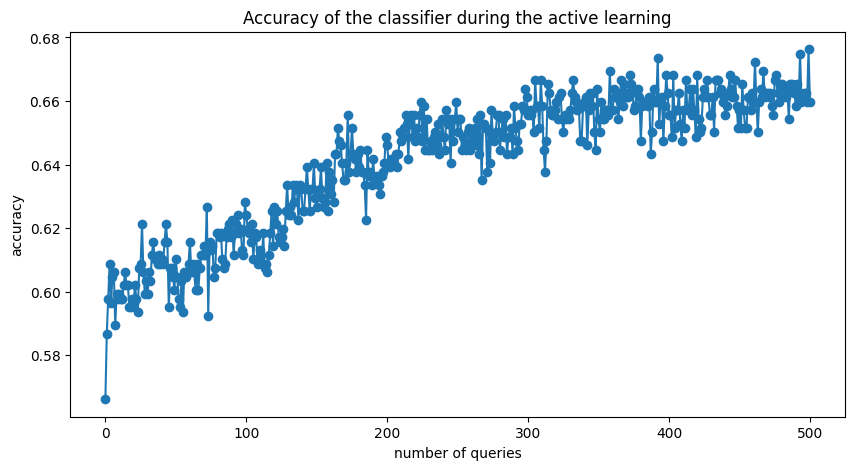

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy of the classifier during the active learning')
plt.plot(range(n_queries+1), accuracy_scores)
plt.scatter(range(n_queries+1), accuracy_scores)
plt.xlabel('number of queries')
plt.ylabel('accuracy')
plt.show()

In [ ]:
plt.scatter(len(query_idx), query_idx)

TypeError: scatter() missing 1 required positional argument: 'y'